# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Titanic Dataset (https://www.kaggle.com/c/titanic/data)

### 1.1.1. Load the dataset and store it as dataframe(numeric) 

Removed NaNs and aribitrary variables like Names, Ticket numbers etc

In [1]:
import pandas as pd
import utils

In [2]:
#Test
filename = "data/titanic/modified_train.csv"
df = utils.get_dataframe_from_csv(filename,sep=',').iloc[:,1:]  #remove label

INFO:root:Input filename has to be space separated data


In [3]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
#test
df1 = df.copy()

In [7]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.10
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs


     Survived  Pclass   Sex   Age  SibSp  Parch     Fare Embarked
134       0.0     3.0  male  28.0    0.0      0  56.4958        S
284       0.0     3.0  male  28.0    0.0      0   9.5000        S
225       NaN     NaN  male   NaN    NaN      0   7.8542        S
526       0.0     2.0  male  25.0    0.0      0  13.0000        S
572       0.0     3.0  male  17.0    1.0      0   7.0542        S
     Survived  Pclass     Sex   Age  SibSp  Parch    Fare Embarked
442       NaN     NaN  female   NaN    NaN      1   79.65        S
686       0.0     2.0    male  21.0    1.0      0   11.50        S
16        0.0     3.0  female  31.0    1.0      0   18.00        S
401       0.0     1.0    male  18.0    1.0      0  108.90        C
487       0.0     2.0    male  26.0    0.0      0   10.50        S
     Survived  Pclass     Sex   Age  SibSp  Parch    Fare Embarked
442         1       1  female  39.0      1      1   79.65        S
686         0       2    male  21.0      1      0   11.50        S
1

## Move below snippet to python function


In [106]:
class Data_PreProcessor:
    def __init__(self, dataframe, categorical_variables = {'Survived', 'Pclass', 'Sex','Embarked'} , logger_level = 20):
        import pandas as pd
        assert isinstance(dataframe, pd.DataFrame)
        
        import logging
        logger = logging.getLogger()
        logger.setLevel(logger_level)
        
        self.dataframe = dataframe
        self.orig_order = dataframe.columns
        
        all_cols = self.dataframe.columns
        self.non_numeric_cols = categorical_variables
        self.numeric_cols = set(self.dataframe.columns) - self.non_numeric_cols
        
        self.max_df = self.dataframe[self.numeric_cols].max()
        self.min_df = self.dataframe[self.numeric_cols].min()

        logging.debug("Columns: "+str(self.non_numeric_cols))

    def get_one_hot_encoded_df(self): 
        '''Given df with cateforical variables, convert to one-hot encoded form'''
        # Replacing NaNs with most common value if Categorical, if not mean value
        self.dataframe = self.dataframe.apply(lambda x: x.fillna(x.mode().iloc[0]) if x.name in self.non_numeric_cols else x.fillna((x.mean()), axis=0)) 

        needed_column_names = []
        for col in self.non_numeric_cols:
            dummy_df = pd.get_dummies(self.dataframe[col], prefix=col)
            self.dataframe = pd.concat( [self.dataframe, dummy_df] , axis = 1)
            self.dataframe.drop(col, inplace= True, axis= 1)
            needed_column_names.append((dummy_df.columns[0],dummy_df.columns[-1]))

        
        self.one_hot_encoded_indexes = [(self.dataframe.columns.get_loc(i[0]), self.dataframe.columns.get_loc(i[1])+1) for i in needed_column_names]
        self.one_hot_encoded_indexes = {indices: i for indices,i in zip(self.one_hot_encoded_indexes,self.non_numeric_cols)}
        

        return self.dataframe
    
    def reverse_one_hot_encoding(self, dataframe):
        """Given dataframe with one hot encoded variables, reverse to original variables """
        assert isinstance(dataframe, pd.DataFrame)
        for index, class_name in self.one_hot_encoded_indexes.items():
            dataframe[class_name] = dataframe.iloc[:,index[0]:index[1]].idxmax(1)
            dataframe[class_name] = dataframe[class_name].apply(lambda x: x.split('_')[-1])

        index_begin = list(self.one_hot_encoded_indexes.keys())[0][0]
        index_end =  list(self.one_hot_encoded_indexes.keys())[-1][-1]
        dataframe.drop(dataframe.columns[index_begin:index_end], axis=1, inplace=True)
        dataframe = dataframe.reindex(self.orig_order, axis=1)
        return dataframe
    
    def get_normalized_dataframe(self, dataframe):
        """Given dataframe with unnormalized data, normalize it to lie between 0 and 1.
        Normalization is only done for numeric data"""
        
        norm_df = (dataframe[self.numeric_cols]- self.min_df) / (self.max_df - self.min_df)
        dataframe.loc[:,self.numeric_cols] = norm_df
        return dataframe
    
    def get_denormalized_dataframe(self, dataframe):
        """Given dataframe with normalized data, return orginal values"""
        
        df = dataframe[self.numeric_cols]*(self.max_df - self.min_df) + (self.min_df)
        dataframe.loc[:,self.numeric_cols]= df
        return dataframe
    

In [9]:
# new_train_df = train_df.copy()
# data_proc_object = Data_PreProcessor(new_train_df, categorical_variables = {'Survived', 'Pclass', 'Sex','Embarked'})

In [10]:
# new_train_df  = data_proc_object.get_one_hot_encoded_df()
# new_train_df = data_proc_object.get_normalized_dataframe(new_train_df)

In [9]:
# new_train_df.head()

In [13]:
# import dataset_module_categorical

In [14]:
# trainset = dataset_module_categorical.DataSetForImputation(new_train_df, data_proc_object.one_hot_encoded_indexes) 

In [15]:
# trainset

Dataframe Size:498, Perc of NaNs: 0.00

In [10]:
# trainset[0]

In [11]:
# trainset[5]

# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [12]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [13]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [23]:
# import Modelling_categorical

In [24]:
# net = Modelling_categorical.DenoisingAutoEncoder(len(trainset.variables()), trainset.one_hot_encoded_indexes)
# #(self, num_variables, one_hot_encoded_indexes, theta=7, input_dropout=0.5, dropout_at_layers = [0], logger_level=10):

In [14]:
# net

## Training

In [19]:
test_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
442,NaN,NaN,female,NaN,NaN,1,79.65,S
686,0.0,2.0,male,21.0,1.0,0,11.50,S
16,0.0,3.0,female,31.0,1.0,0,18.00,S
401,0.0,1.0,male,18.0,1.0,0,108.90,C
487,0.0,2.0,male,26.0,0.0,0,10.50,S


In [20]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
134,0.0,3.0,male,28.0,0.0,0,56.4958,S
284,0.0,3.0,male,28.0,0.0,0,9.5000,S
225,NaN,NaN,male,NaN,NaN,0,7.8542,S
526,0.0,2.0,male,25.0,0.0,0,13.0000,S
572,0.0,3.0,male,17.0,1.0,0,7.0542,S


In [107]:
import torch.utils.data as td
from torch.optim import Adam

import dataset_module_categorical
import Modelling_categorical

new_train_df = train_df.copy()
data_proc_train_object = Data_PreProcessor(new_train_df, categorical_variables = {'Survived', 'Pclass', 'Sex', 'Embarked'})
new_train_df = data_proc_train_object.get_one_hot_encoded_df()
new_train_df = data_proc_train_object.get_normalized_dataframe(new_train_df) #Normalize the numerical data

new_test_df = test_df.copy()
data_proc_test_object = Data_PreProcessor(new_test_df, categorical_variables = {'Survived', 'Pclass', 'Sex', 'Embarked'})
new_test_df = data_proc_test_object.get_one_hot_encoded_df()
new_test_df = data_proc_test_object.get_normalized_dataframe(new_test_df) #Normalize the numerical data

trainset = dataset_module_categorical.DataSetForImputation(new_train_df, data_proc_train_object.one_hot_encoded_indexes)
testset = dataset_module_categorical.DataSetForImputation(new_test_df, data_proc_test_object.one_hot_encoded_indexes)

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [46]:
import Modelling_categorical
net = Modelling_categorical.DenoisingAutoEncoder(len(trainset.variables()), trainset.one_hot_encoded_indexes, theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [47]:
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", train_loader = train_loader, val_loader = val_loader, logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
        
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
            
        #Validation curve
        val_loss = 0.0
        net.eval()
        for x,d in val_loader:
            x[torch.isnan(x)]=0
            d[torch.isnan(d)]=0
            x = x.to(device)
            with torch.no_grad():
                d= d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y,d))
            val_loss+=loss
        net.train()
        #Write Val loss to file every epoch
        with open(model_name+"/artifacts/val_loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {val_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [49]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout_Categorical_Normalized"

In [50]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 0.5188


Epoch number:19 Loss: 0.4472


Epoch number:29 Loss: 0.3742


Epoch number:39 Loss: 0.3530


Epoch number:49 Loss: 0.3371


Epoch number:59 Loss: 0.3237


Epoch number:69 Loss: 0.3148


Epoch number:79 Loss: 0.3044


Epoch number:89 Loss: 0.3014


Epoch number:99 Loss: 0.2940


In [148]:
train_model(301,501, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:310 Loss: 0.2518


Epoch number:320 Loss: 0.2546


Epoch number:330 Loss: 0.2558


Epoch number:340 Loss: 0.2500


Epoch number:350 Loss: 0.2590


Epoch number:360 Loss: 0.2510


Epoch number:370 Loss: 0.2540


Epoch number:380 Loss: 0.2540


Epoch number:390 Loss: 0.2521


Epoch number:400 Loss: 0.2524


Epoch number:410 Loss: 0.2516


Epoch number:420 Loss: 0.2556


Epoch number:430 Loss: 0.2520


Epoch number:440 Loss: 0.2502


Epoch number:450 Loss: 0.2523


Epoch number:460 Loss: 0.2435


Epoch number:470 Loss: 0.2591


Epoch number:480 Loss: 0.2576


Epoch number:490 Loss: 0.2564


Epoch number:500 Loss: 0.2487



In [ ]:
#torch.autograd.set_detect_anomaly(False)

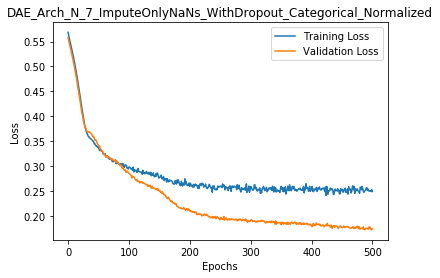

In [149]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [ ]:
# '''Model Loading from saved point'''
# import Modelling_categorical
# net = Modelling_categorical.DenoisingAutoEncoder(len(trainset.variables()), trainset.one_hot_encoded_indexes, theta = 7, input_dropout=0.5)
# net.load_state_dict(torch.load(f"./{model_name}/artifacts/saved_model/model_at_epoch50"))
# net.eval()

# 4. Testing

In [150]:
net = net.eval()
print((net(trainset[3][0]).detach()))
print(trainset[3][0])

tensor([ 0.4774,  0.0687,  0.0252, -0.0082,  0.2785,  0.7215,  0.7152,  0.2848,
         0.2108,  0.2043,  0.5849,  0.2187,  0.4721,  0.3092])
tensor([0.3459, 0.0000, 0.0000, 0.0254, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000])


In [151]:
test_a = (net(trainset[3][0]).detach())

In [152]:
test_a

tensor([ 0.4774,  0.0687,  0.0252, -0.0082,  0.2785,  0.7215,  0.7152,  0.2848,
         0.2108,  0.2043,  0.5849,  0.2187,  0.4721,  0.3092])

## Move this to separate file or Utils?

In [153]:
def convert_probabilities_to_one_hot(input_tensor, input_tensor_one_hot_indices):
    """Given prediction, correct indices of one-hot-encoded variables =>
    Returns predictions by rounding up the max probabilities to 1
    Creates new copy, doesn't modify original"""
    input_t  = input_tensor
    for i,j in input_tensor_one_hot_indices:
        temp_ind = torch.argmax(input_t[i:j])
        input_t[i:j]= 0.0
        input_t[i+temp_ind] = 1.0
    return input_t

In [154]:
convert_probabilities_to_one_hot(test_a, data_proc_train_object.one_hot_encoded_indexes)

tensor([ 0.4774,  0.0687,  0.0252, -0.0082,  0.0000,  1.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000])

In [155]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, data_proc_object = None, device=None, logger_level=20):
    """
    Function to evaluate the model on test set
    """
    assert isinstance(net, Modelling_categorical.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module_categorical.DataSetForImputation)
    assert isinstance(data_proc_object, Data_PreProcessor)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
    
    test_df_one_hot  = data_proc_object.get_one_hot_encoded_df()
    test_df_one_hot = data_proc_object.get_normalized_dataframe(test_df_one_hot) #Normalize the numerical data
    test_df_tensor = torch.tensor(test_df_one_hot.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    with torch.no_grad():
        pred = net(test_df_tensor)
        
    pred = pd.DataFrame(pred, columns = test_df_one_hot.columns)
    pred = pred.applymap(lambda x: x.item()) #to convert all tensors to values
    
    pred =  data_proc_object.reverse_one_hot_encoding(pred)  #get full prediction in dataframe format from tensor
    pred = data_proc_object.get_denormalized_dataframe(pred) #Denormalize the predictions to get values in correct range
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [156]:
new_test_df = test_df.copy()
data_proc_test_object = Data_PreProcessor(new_test_df, categorical_variables = {'Survived', 'Pclass', 'Sex', 'Embarked'})

In [157]:
prediction = test_model(net=net, test_df=new_test_df, trainset=trainset, data_proc_object=data_proc_test_object, device=device, logger_level=20)

In [158]:
prediction.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,female,28.8836,0.83811,1,79.65,S
1,0,2,male,21,1,0,11.5,S
2,0,3,female,31,1,0,18,S
3,0,1,male,18,1,0,108.9,C
4,0,2,male,26,0,0,10.5,S


## Move this to separate file or Utils?

In [159]:
def compare_NaNs_in_prediction(dataframe, full_valued_dataframe, prediction):
    """Only retrieve NaNs of the dataframe and compare it with full_valued_dataframe"""
    assert all([isinstance(i, pd.DataFrame) for i in (dataframe, full_valued_dataframe, prediction)])
    
    df_dataframe = dataframe.reset_index(drop=True)
    df_full_valued_dataframe = full_valued_dataframe.reset_index(drop=True)
    df_prediction = prediction.reset_index(drop=True)

    pred_df = df_prediction[df_dataframe.isna().any(axis=1)]
    orign_df = df_full_valued_dataframe[df_dataframe.isna().any(axis=1)]
    
    return pred_df, orign_df

In [160]:
pred_df, orign_df = compare_NaNs_in_prediction(test_df, full_test_df, prediction)

In [161]:
pred_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,female,28.8836,0.83811,1,79.65,S
11,0.0,3.0,male,24.0111,1.66481,0,35.5,S
26,0.0,3.0,female,28.4754,0.828126,0,8.6625,S
29,0.0,3.0,female,30.0466,0.557976,0,76.7292,C
31,0.0,3.0,female,28.4166,0.846348,1,27,S


In [162]:
orign_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,female,39.0,1,1,79.6500,S
11,0,1,male,45.0,0,0,35.5000,S
26,0,3,female,20.0,0,0,8.6625,S
29,1,1,female,49.0,1,0,76.7292,C
31,1,2,female,24.0,2,1,27.0000,S


In [164]:
pred_df['Pclass'].value_counts()

3.0    47
Name: Pclass, dtype: int64